<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20fuzzy%20Takagi-Sugeno%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Training Takagi-Sugeno model...
Making predictions...
Training MSE: 14.69, MAE: 2.62
Testing MSE: 17.76, MAE: 3.33


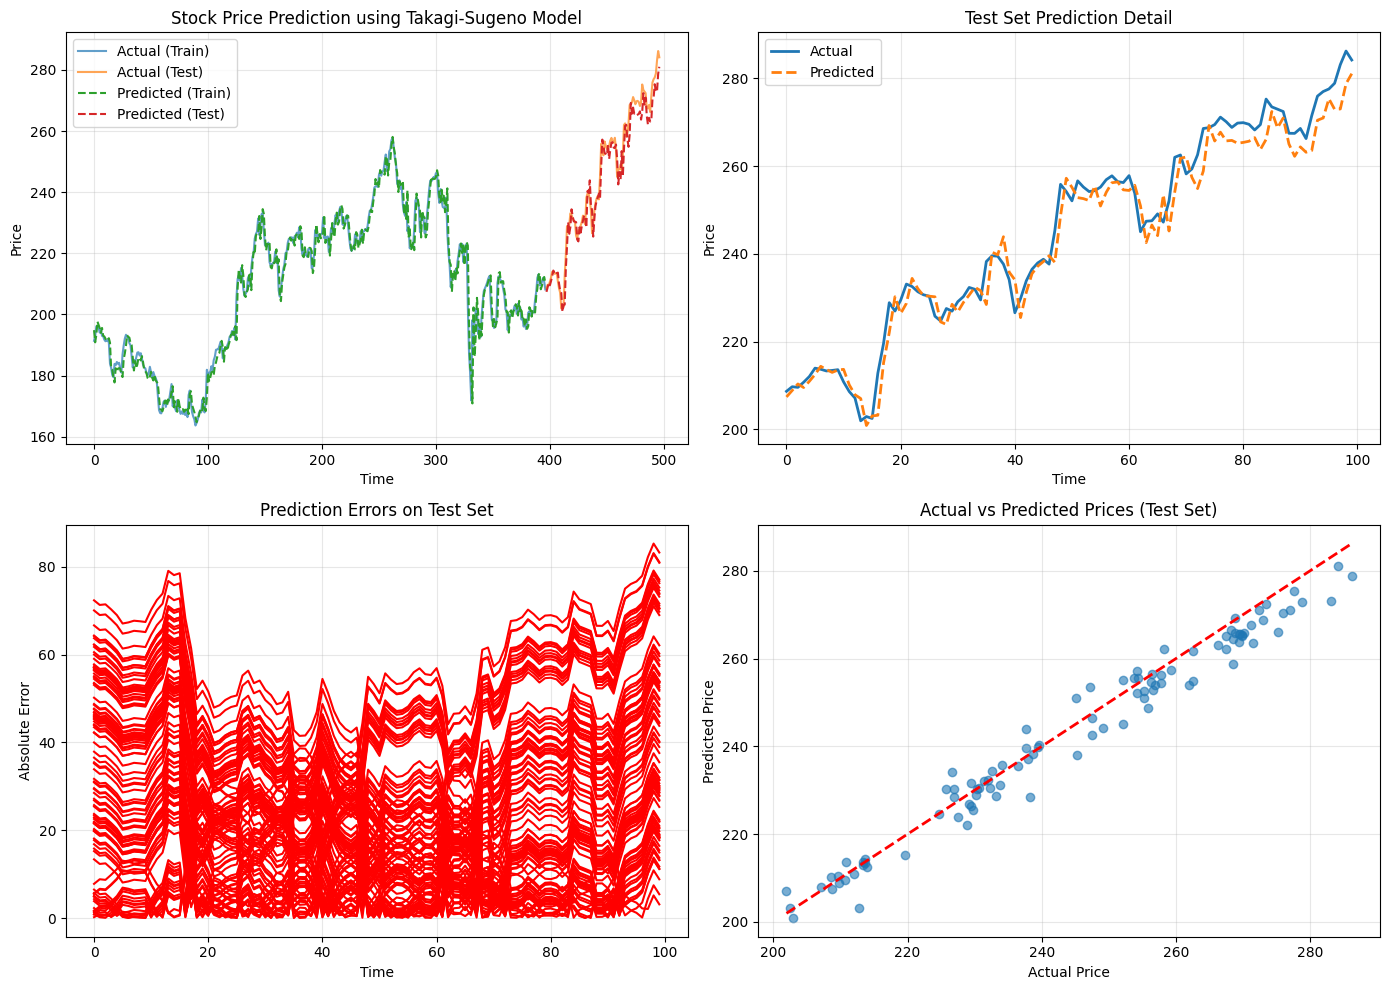


Takagi-Sugeno Model Explanation:
Number of rules: 3
Number of inputs: 5
Consequent function order: 1

Fuzzy Sets (for each input):
  Input 1: Centers = [163.66 210.76 257.85], Sigma = 15.70
  Input 2: Centers = [163.66 210.76 257.85], Sigma = 15.70
  Input 3: Centers = [163.66 210.76 257.85], Sigma = 15.70
  Input 4: Centers = [163.66 210.76 257.85], Sigma = 15.70
  Input 5: Centers = [163.66 210.76 257.85], Sigma = 15.70

Consequent Parameters (for each rule):
  Rule 1: [28.759 -0.108  0.173 -0.034 -0.124  0.927]
  Rule 2: [ 3.483 -0.029  0.152 -0.197 -0.183  1.24 ]
  Rule 3: [39.456  0.349 -0.84   0.592 -0.54   1.277]


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Define the Takagi-Sugeno Fuzzy Model class
class TakagiSugenoModel:
    def __init__(self, n_rules=3, n_inputs=2, order=1):
        """
        Initialize the Takagi-Sugeno model
        :param n_rules: Number of fuzzy rules
        :param n_inputs: Number of input variables
        :param order: Order of consequent functions (0 for constant, 1 for linear)
        """
        self.n_rules = n_rules
        self.n_inputs = n_inputs
        self.order = order
        self.fuzzy_sets = None
        self.consequent_params = None

    def _initialize_fuzzy_sets(self, X):
        """Initialize fuzzy sets using clustering"""
        # Simple clustering-based initialization
        self.fuzzy_sets = []
        for i in range(self.n_inputs):
            min_val, max_val = X[:, i].min(), X[:, i].max()
            centers = np.linspace(min_val, max_val, self.n_rules)
            sigma = (max_val - min_val) / (2 * self.n_rules)
            self.fuzzy_sets.append((centers, sigma))

    def _gaussian_membership(self, x, center, sigma):
        """Calculate Gaussian membership function"""
        # Ensure center is a scalar
        center = float(center)
        # Ensure x is a 1D array
        x = np.asarray(x).flatten()
        return np.exp(-0.5 * ((x - center) / sigma) ** 2)

    def _compute_firing_strengths(self, X):
        """Compute firing strengths for each rule"""
        n_samples = X.shape[0]
        firing_strengths = np.zeros((n_samples, self.n_rules))

        for i in range(self.n_rules):
            rule_strength = np.ones(n_samples)
            for j in range(self.n_inputs):
                centers, sigma = self.fuzzy_sets[j]
                # Extract the center for the i-th rule of the j-th input
                center_for_rule = centers[i]
                # Calculate membership for all samples for this input and rule
                mu = self._gaussian_membership(X[:, j], center_for_rule, sigma)
                # Multiply membership values for this rule across all inputs
                rule_strength = rule_strength * mu
            # Store the final firing strength for this rule
            firing_strengths[:, i] = rule_strength

        return firing_strengths

    def fit(self, X, y):
        """Fit the Takagi-Sugeno model"""
        # CRITICAL FIX: Ensure y is a 1D array to prevent shape issues in matrix operations.
        # If y is (n_samples, 1), it needs to be flattened to (n_samples,).
        y = y.flatten()

        self._initialize_fuzzy_sets(X)

        # Compute firing strengths
        firing_strengths = self._compute_firing_strengths(X)

        # Add bias term for linear consequent functions
        if self.order == 1:
            X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        else:
            X_with_bias = np.ones((X.shape[0], 1))

        # Calculate consequent parameters for each rule
        self.consequent_params = np.zeros((self.n_rules, X_with_bias.shape[1]))

        for i in range(self.n_rules):
            # Weighted least squares
            weights = firing_strengths[:, i]
            # Make sure weights is 1D
            weights = weights.flatten()
            W = np.diag(weights)

            try:
                # Calculate parameters: theta = (X^T * W * X)^(-1) * X^T * W * y
                XtWX = X_with_bias.T @ W @ X_with_bias
                XtW = X_with_bias.T @ W
                self.consequent_params[i] = np.linalg.solve(XtWX, XtW @ y)
            except np.linalg.LinAlgError:
                # Fallback to pseudo-inverse if matrix is singular
                self.consequent_params[i] = np.linalg.pinv(X_with_bias.T @ W @ X_with_bias) @ (X_with_bias.T @ W @ y)

    def predict(self, X):
        """Make predictions using the trained model"""
        firing_strengths = self._compute_firing_strengths(X)

        # Add bias term for linear consequent functions
        if self.order == 1:
            X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        else:
            X_with_bias = np.ones((X.shape[0], 1))

        # Calculate outputs for each rule
        rule_outputs = np.zeros((X.shape[0], self.n_rules))
        for i in range(self.n_rules):
            rule_outputs[:, i] = X_with_bias @ self.consequent_params[i]

        # Calculate final output using weighted average
        weighted_outputs = firing_strengths * rule_outputs
        total_firing_strength = firing_strengths.sum(axis=1)

        # Avoid division by zero
        total_firing_strength = np.where(total_firing_strength == 0, 1e-10, total_firing_strength)
        y_pred = weighted_outputs.sum(axis=1) / total_firing_strength

        return y_pred

# Download stock data
def download_stock_data(ticker="AAPL", period="2y"):
    """Download stock data from Yahoo Finance"""
    stock = yf.download(ticker, period=period)
    return stock['Close'].values

# Prepare time series data for training
def prepare_time_series_data(data, lookback=5):
    """Prepare time series data with lookback window"""
    X, y = [], []
    for i in range(lookback, len(data)):
        # Ensure each slice of data is 1D to prevent X from becoming 3D
        X.append(data[i-lookback:i].flatten())
        y.append(data[i])
    return np.array(X), np.array(y)

# Main execution
def main():
    # Download stock data
    print("Downloading stock data...")
    stock_prices = download_stock_data("AAPL", "2y")

    # Prepare data for the model
    lookback = 5
    X, y = prepare_time_series_data(stock_prices, lookback)

    # Split data into train and test sets
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Create and train the Takagi-Sugeno model
    print("Training Takagi-Sugeno model...")
    ts_model = TakagiSugenoModel(n_rules=3, n_inputs=lookback, order=1)
    ts_model.fit(X_train, y_train)

    # Make predictions
    print("Making predictions...")
    y_train_pred = ts_model.predict(X_train)
    y_test_pred = ts_model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Training MSE: {train_mse:.2f}, MAE: {train_mae:.2f}")
    print(f"Testing MSE: {test_mse:.2f}, MAE: {test_mae:.2f}")

    # Create plots
    plt.figure(figsize=(14, 10))

    # Plot 1: Training and testing predictions
    plt.subplot(2, 2, 1)
    plt.plot(y_train, label='Actual (Train)', alpha=0.7)
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual (Test)', alpha=0.7)
    plt.plot(y_train_pred, label='Predicted (Train)', linestyle='--')
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_pred, label='Predicted (Test)', linestyle='--')
    plt.title('Stock Price Prediction using Takagi-Sugeno Model')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Test set zoomed in
    plt.subplot(2, 2, 2)
    test_range = range(len(y_test))
    plt.plot(test_range, y_test, label='Actual', linewidth=2)
    plt.plot(test_range, y_test_pred, label='Predicted', linestyle='--', linewidth=2)
    plt.title('Test Set Prediction Detail')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Prediction errors
    plt.subplot(2, 2, 3)
    test_errors = np.abs(y_test - y_test_pred)
    plt.plot(test_range, test_errors, color='red', label='Absolute Errors')
    plt.title('Prediction Errors on Test Set')
    plt.xlabel('Time')
    plt.ylabel('Absolute Error')
    #plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: Actual vs Predicted scatter plot
    plt.subplot(2, 2, 4)
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices (Test Set)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Demonstrate how the model works internally
    print("\nTakagi-Sugeno Model Explanation:")
    print(f"Number of rules: {ts_model.n_rules}")
    print(f"Number of inputs: {ts_model.n_inputs}")
    print(f"Consequent function order: {ts_model.order}")
    print("\nFuzzy Sets (for each input):")
    for i, (centers, sigma) in enumerate(ts_model.fuzzy_sets):
        print(f"  Input {i+1}: Centers = {centers.round(2)}, Sigma = {sigma:.2f}")

    print("\nConsequent Parameters (for each rule):")
    for i, params in enumerate(ts_model.consequent_params):
        print(f"  Rule {i+1}: {params.round(3)}")

# Run the main function
if __name__ == "__main__":
    main()